# Gradient Computation Benchmark

This notebook benchmarks gradient computation on CPU and GPU using NumPy and CuPy. It validates and compares performance between CPU and GPU implementations of gradient computations.

In [1]:
import numpy as np
import cupy as cp
import timeit
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
import pycuda.driver as cuda
import pycuda.autoinit

# Define the number of samples here
NUM_SAMPLES = 20  # Change this value to vary the number of samples

# Initialize CUDA
cuda.init()


In [2]:
# Function to retrieve GPU information using PyCUDA
def get_gpu_info_pycuda():
    device = cuda.Device(0)
    properties = device.get_attributes()
    gpu_info = {
        'name': device.name(),
        'total_memory': device.total_memory() / (1024**3),  # Convert to GB
        'clock_rate': device.get_attribute(cuda.device_attribute.CLOCK_RATE) / 1e3,  # MHz
        'cores': properties[cuda.device_attribute.MULTIPROCESSOR_COUNT] * 128  # Correct number of cores
    }
    return gpu_info

# Retrieve and print GPU specifications
gpu_info = get_gpu_info_pycuda()
print(f"GPU Info: {gpu_info}")


GPU Info: {'name': 'NVIDIA GeForce RTX 3060 Laptop GPU', 'total_memory': 5.99951171875, 'clock_rate': 1425.0, 'cores': 3840}


In [3]:
# Calculate maximum memory pool size and set to 80%
def set_memory_pool_limit():
    device = cuda.Device(0)
    total_memory = device.total_memory() / (1024**3)  # Convert to GB
    max_memory_pool = total_memory * 0.8  # Use 80% of total memory
    cp.get_default_memory_pool().set_limit(int(max_memory_pool * 1024**3))  # Convert GB to bytes
    print(f"Memory pool set to: {max_memory_pool} GB")

set_memory_pool_limit()


Memory pool set to: 4.799609375 GB


In [4]:
# Function to generate example data
def generate_example_data(samples=NUM_SAMPLES):
    np.random.seed(0)
    return np.random.rand(samples, 60, 60, 60, 3)


In [5]:
# Define CPU and GPU gradient computation functions
def gradient_kernel_cpu(data):
    samples, x, y, z, components = data.shape
    gradients = np.zeros((samples, x, y, z, 9))
    for i in range(samples):
        for comp in range(components):
            gradients[i, :, :, :, comp*3] = np.gradient(data[i, :, :, :, comp], axis=0)
            gradients[i, :, :, :, comp*3+1] = np.gradient(data[i, :, :, :, comp], axis=1)
            gradients[i, :, :, :, comp*3+2] = np.gradient(data[i, :, :, :, comp], axis=2)
    return gradients

def compute_gradients(data, axis):
    return cp.gradient(data, axis=axis)

def gradient_kernel_gpu(data):
    samples, x, y, z, components = data.shape
    gradients = cp.zeros((samples, x, y, z, 9), dtype=cp.float32)
    for i in range(samples):
        for comp in range(components):
            gradients[i, :, :, :, comp*3] = compute_gradients(data[i, :, :, :, comp], axis=0)
            gradients[i, :, :, :, comp*3+1] = compute_gradients(data[i, :, :, :, comp], axis=1)
            gradients[i, :, :, :, comp*3+2] = compute_gradients(data[i, :, :, :, comp], axis=2)
    return gradients


In [6]:
# Validation function using NumPy
def validate_with_numpy(data):
    try:
        gradients_kernel = gradient_kernel_cpu(data)
        gradients_numpy = np.zeros_like(gradients_kernel)
        for i in range(data.shape[0]):
            for comp in range(data.shape[-1]):
                gradients_numpy[i, :, :, :, comp*3] = np.gradient(data[i, :, :, :, comp], axis=0)
                gradients_numpy[i, :, :, :, comp*3+1] = np.gradient(data[i, :, :, :, comp], axis=1)
                gradients_numpy[i, :, :, :, comp*3+2] = np.gradient(data[i, :, :, :, comp], axis=2)
        return np.allclose(gradients_kernel, gradients_numpy)
    except Exception as e:
        print(f"Validation error: {e}")
        return False


In [7]:
# Timing and GFLOPS functions
def timing_analysis_gpu(data):
    start_time = timeit.default_timer()
    try:
        gradient_kernel_gpu(data)
    except Exception as e:
        print(f"Error during GPU computation: {e}")
        return float('inf')
    end_time = timeit.default_timer()
    return end_time - start_time

def timing_analysis_cpu(data):
    start_time = timeit.default_timer()
    gradient_kernel_cpu(data)
    end_time = timeit.default_timer()
    return end_time - start_time

def calculate_flops(data_shape):
    num_elements = np.prod(data_shape)
    num_components = data_shape[-1]
    total_flops = num_elements * num_components * 3
    return total_flops


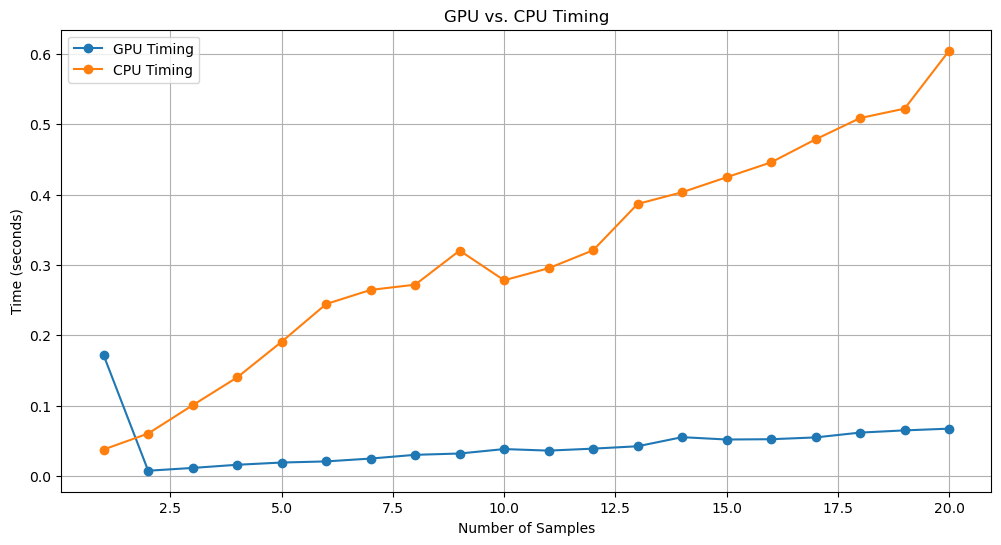

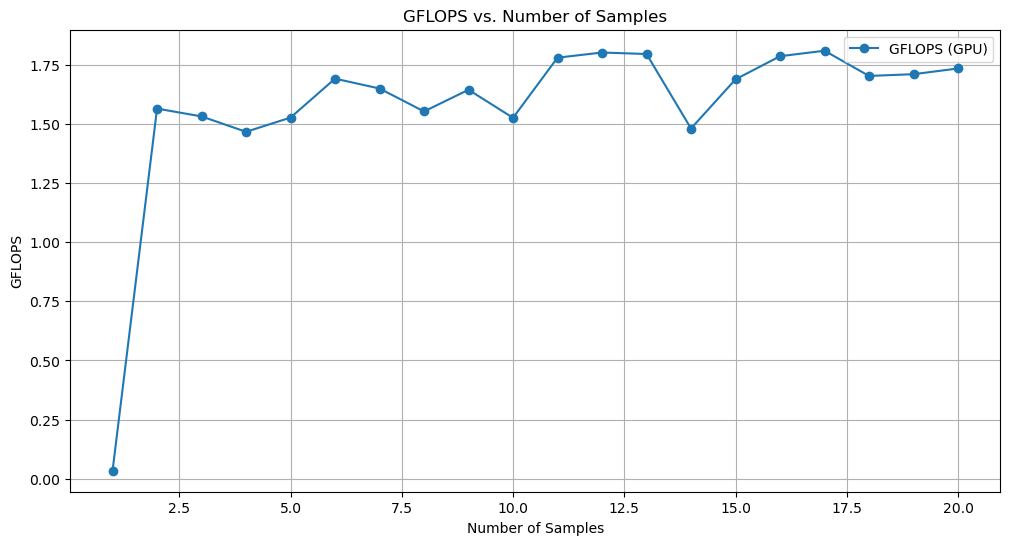

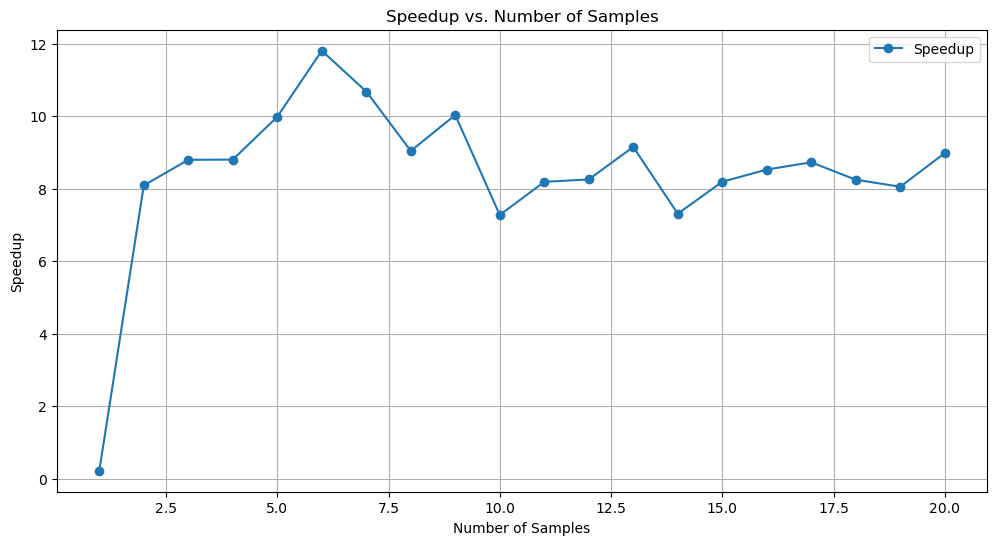

In [8]:
# Perform timing and GFLOPS analysis
sample_sizes = list(range(1, NUM_SAMPLES + 1))
gpu_times = []
cpu_times = []
gflops = []
speedups = []

for size in sample_sizes:
    data = cp.asarray(generate_example_data(samples=size))
    cpu_time = timing_analysis_cpu(generate_example_data(samples=size))
    gpu_time = timing_analysis_gpu(data)
    if gpu_time > 0:
        gpu_times.append(gpu_time)
        cpu_times.append(cpu_time)
        gflops_val = (calculate_flops(data.shape) / gpu_time) / 1e9  # Convert to GFLOPS
        gflops.append(gflops_val)
        speedup = cpu_time / gpu_time
        speedups.append(speedup)
    else:
        gpu_times.append(float('inf'))
        cpu_times.append(cpu_time)
        gflops.append(float('inf'))
        speedups.append(float('inf'))

# Plot GPU vs. CPU Timing
plt.figure(figsize=(12, 6))
plt.plot(sample_sizes, gpu_times, label='GPU Timing', marker='o')
plt.plot(sample_sizes, cpu_times, label='CPU Timing', marker='o')
plt.xlabel('Number of Samples')
plt.ylabel('Time (seconds)')
plt.title('GPU vs. CPU Timing')
plt.legend()
plt.grid(True)
plt.show()

# Plot GFLOPS vs. Samples
plt.figure(figsize=(12, 6))
plt.plot(sample_sizes, gflops, label='GFLOPS (GPU)', marker='o')
plt.xlabel('Number of Samples')
plt.ylabel('GFLOPS')
plt.title('GFLOPS vs. Number of Samples')
plt.legend()
plt.grid(True)
plt.show()

# Plot Speedup vs. Samples
plt.figure(figsize=(12, 6))
plt.plot(sample_sizes, speedups, label='Speedup', marker='o')
plt.xlabel('Number of Samples')
plt.ylabel('Speedup')
plt.title('Speedup vs. Number of Samples')
plt.legend()
plt.grid(True)
plt.show()
